Dataset shape: (506, 14)


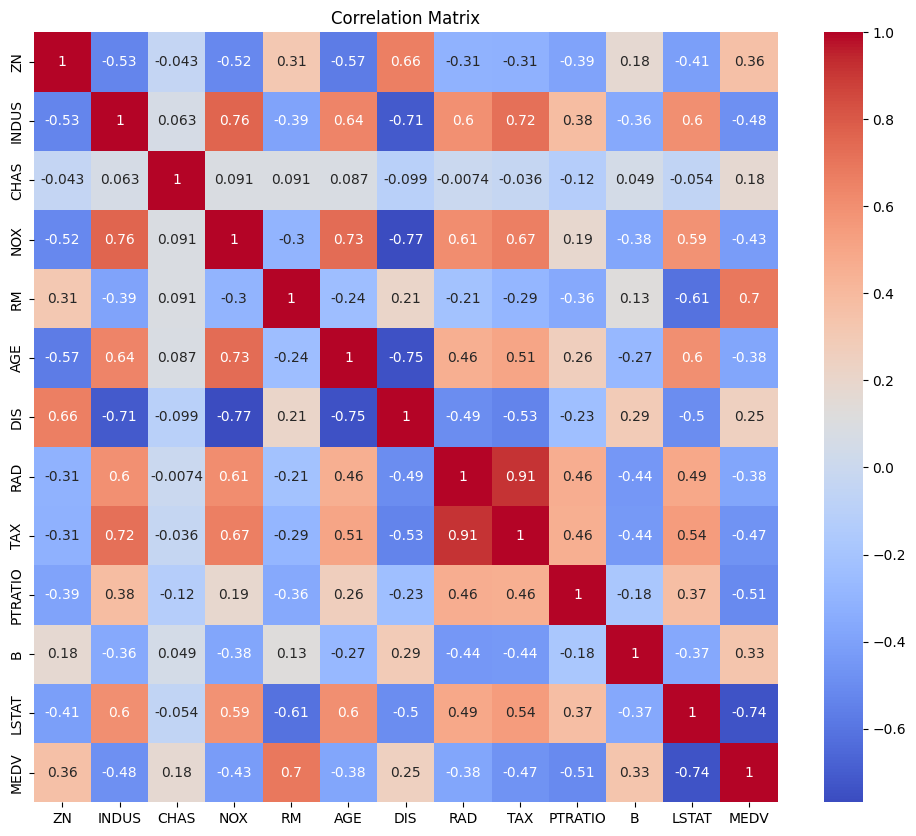

Best number of features: 8
Best parameters found: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Cross-Validation MSE: 32.98224802444695
MSE: 26.41712305646168
R2 Score: 0.6422400544054365
MAE: 1.1587843851592452
MAPE: 0.8509196448238862
RMSE: 5.139759046537267


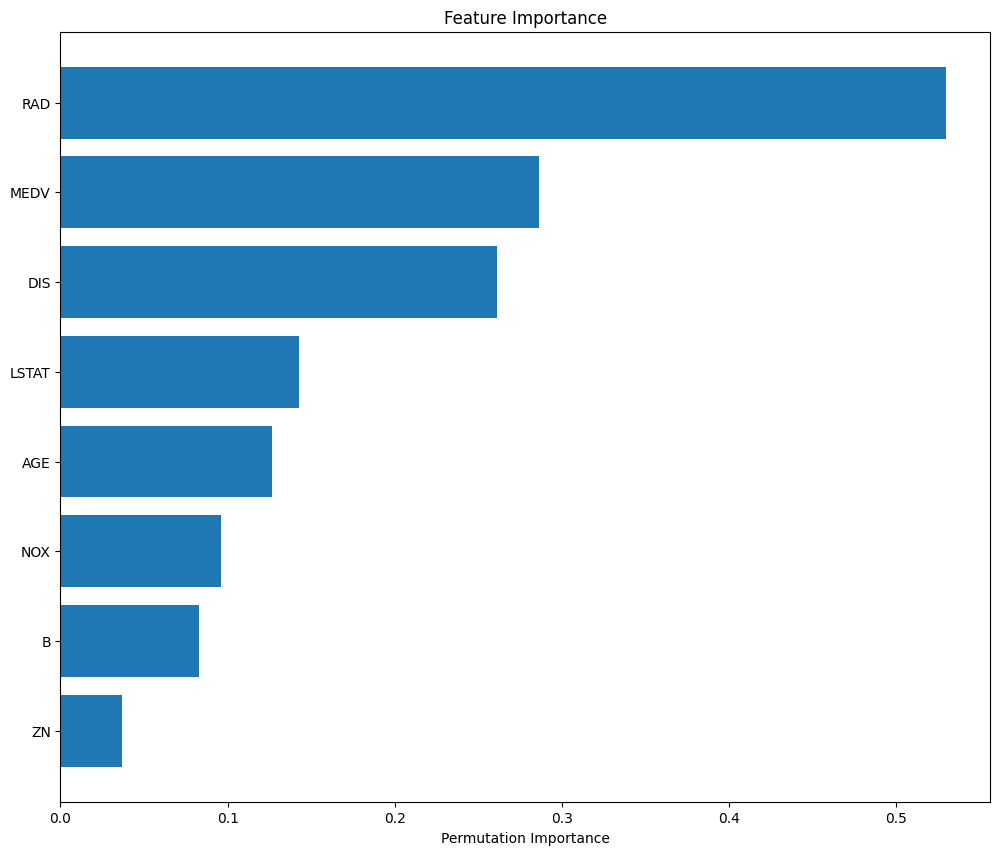

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

# CSVファイルの読み込み
file_path = 'C:/Users/thisi/OneDrive/デスクトップ/Dateset1.csv'
data = pd.read_csv(file_path)

# データのサイズ確認
print(f'Dataset shape: {data.shape}')

# 説明変数と目的変数の設定
target_variable = 'CRIM'
X = data.drop(columns=[target_variable])
y = data[target_variable]

# 説明変数間の相関関係を示す画像の出力
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 特徴量の数を変えてRFEを実施し、最も良い精度を持つモデルを選択
best_score = float('inf')
best_num_features = 0
best_selector = None

for num_features in range(1, X.shape[1] + 1):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=num_features, step=1)
    selector = selector.fit(X_scaled, y)
    
    X_selected = X.iloc[:, selector.support_]
    X_selected_scaled = scaler.fit_transform(X_selected)
    
    # GridSearchCVによるハイパーパラメータの調整
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'epsilon': [0.001, 0.01, 0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_selected_scaled, y)
    
    # 最適なハイパーパラメータでのモデルの評価
    best_svr = grid_search.best_estimator_
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(best_svr, X_selected_scaled, y, cv=kfold, scoring='neg_mean_squared_error')
    mean_score = -cv_results.mean()
    
    if mean_score < best_score:
        best_score = mean_score
        best_num_features = num_features
        best_selector = selector

# 最適な特徴量数で再構築
X_selected = X.iloc[:, best_selector.support_]
X_selected_scaled = scaler.fit_transform(X_selected)
print(f'Best number of features: {best_num_features}')

# GridSearchCVによるハイパーパラメータの調整
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_selected_scaled, y)

# 最適なハイパーパラメータの表示
print(f'Best parameters found: {grid_search.best_params_}')

# 最適なパラメータでのモデルの再構築
best_svr = grid_search.best_estimator_

# k分割交差検定の実施
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_val_score(best_svr, X_selected_scaled, y, cv=kfold, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_results.mean()}')

# モデルの評価指標の出力
best_svr.fit(X_selected_scaled, y)
y_pred = best_svr.predict(X_selected_scaled)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

# 全データセットに対して予測を行い、実測値と予測値の誤差を出力
errors = y - y_pred
results = pd.DataFrame({'Actual': y, 'Predicted': y_pred, 'Error': errors})
results.to_csv('SVR4_predictions.csv', index=False)

# 特徴量の重要度を示す画像の出力
perm_importance = permutation_importance(best_svr, X_selected_scaled, y, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(12, 10))
plt.barh(X.columns[best_selector.support_][sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()
